# <span style="color:#8e44ad"> P7 - Implémentez un modèle de scoring </span>
## <span style="color:#8e44ad"> Notebook 1 - Exploration et preprocessing </span>

### Description des données :  
* application_{train|test}.csv:
    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET)  
    - Static data for all applications. One row represents one loan in our data sample  
* bureau.csv :
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).  
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.  
* bureau_balance.csv :
    - Monthly balances of previous credits in Credit Bureau.  
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.  
* POS_CASH_balance.csv :
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.  
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.  
* credit_card_balance.csv :
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.  
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.  
* previous_application.csv :
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.
* installments_payments.csv :
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.  
    - There is a) one row for every payment that was made plus b) one row each for missed payment.  
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.  
* HomeCredit_columns_description.csv :
    - This file contains descriptions for the columns in the various data files.

<img src="Schema_fichiers.png">

# <span style="color: #8e44ad "> 1 - Importation des données </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import pickle
%load_ext pycodestyle_magic

pd.options.display.max_columns = None

In [2]:
t0 = time.time()

bureau = pd.read_csv('./Donnees/bureau.csv')
bureau_balance = pd.read_csv('./Donnees/bureau_balance.csv')
credit_card_balance = pd.read_csv('./Donnees/credit_card_balance.csv')
HomeCredit_columns_description = pd.read_csv('./Donnees/HomeCredit_columns_description.csv',encoding='unicode_escape')
installments_payments = pd.read_csv('./Donnees/installments_payments.csv')
POS_CASH_balance = pd.read_csv('./Donnees/POS_CASH_balance.csv')
sample_submission = pd.read_csv('./Donnees/sample_submission.csv')
app_train = pd.read_csv('./Donnees/application_train.csv')
app_test = pd.read_csv('./Donnees/application_test.csv')
previous_app = pd.read_csv('./Donnees/previous_application.csv')
print(f'Le fichier bureau contient {bureau.shape[0]} lignes et {bureau.shape[1]} colonnes')
print(f'Le fichier bureau_balance contient {bureau_balance.shape[0]} lignes et {bureau_balance.shape[1]} colonnes')
print(f'Le fichier credit_card_balance contient {credit_card_balance.shape[0]} lignes et {credit_card_balance.shape[1]} colonnes')
print(f'Le fichier HomeCredit_columns_description contient {HomeCredit_columns_description.shape[0]} lignes et {HomeCredit_columns_description.shape[1]} colonnes')
print(f'Le fichier installments_payments contient {installments_payments.shape[0]} lignes et {installments_payments.shape[1]} colonnes')
print(f'Le fichier POS_CASH_balance contient {POS_CASH_balance.shape[0]} lignes et {POS_CASH_balance.shape[1]} colonnes'.format())
print(f'Le fichier sample_submission contient {sample_submission.shape[0]} lignes et {sample_submission.shape[1]} colonnes'.format())
print(f'Le fichier app_train contient {app_train.shape[0]} lignes et {app_train.shape[1]} colonnes'.format())
print(f'Le fichier app_test contient {app_test.shape[0]} lignes et {app_test.shape[1]} colonnes'.format())
print(f'Le fichier previous_app contient {previous_app.shape[0]} lignes et {previous_app.shape[1]} colonnes'.format())

print('\n Temps de chargement des données : ', round(time.time()-t0, 2), ' secondes')

Le fichier bureau contient 1716428 lignes et 17 colonnes
Le fichier bureau_balance contient 27299925 lignes et 3 colonnes
Le fichier credit_card_balance contient 3840312 lignes et 23 colonnes
Le fichier HomeCredit_columns_description contient 219 lignes et 5 colonnes
Le fichier installments_payments contient 13605401 lignes et 8 colonnes
Le fichier POS_CASH_balance contient 10001358 lignes et 8 colonnes
Le fichier sample_submission contient 48744 lignes et 2 colonnes
Le fichier app_train contient 307511 lignes et 122 colonnes
Le fichier app_test contient 48744 lignes et 121 colonnes
Le fichier previous_app contient 1670214 lignes et 37 colonnes

 Temps de chargement des données :  21.53  secondes


# <span style="color: #8e44ad "> 1 - Physionnomie des données </span>

**bureau**

In [3]:
print(bureau.info())
bureau.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


**bureau_balance**

In [4]:
print(bureau_balance.info())
bureau_balance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


**credit_card_balance**

In [5]:
print(credit_card_balance.info())
credit_card_balance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


**installments_payments**

In [6]:
print(installments_payments.info())
installments_payments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


**POS_CASH_balance**

In [7]:
print(POS_CASH_balance.info())
POS_CASH_balance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


**previous_app**

In [8]:
print(previous_app.info())
previous_app.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**app_train**

In [9]:
print(app_train.info())
app_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
# Recherche des colonnes différentes entre app_train et app_test
app_train.columns.difference(app_test.columns)

Index(['TARGET'], dtype='object')

La seule différence entre le fichier train et test est la colonne TARGET

**HomeCredit_columns_description**

In [11]:
print(HomeCredit_columns_description.info())

# HomeCredit_columns_description permet d'avoir un détail de la description des colonnes dans l'ensemble des fichiers
HomeCredit_columns_description[HomeCredit_columns_description['Table']=='application_{train|test}.csv'][0:25]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB
None


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [12]:
HomeCredit_columns_description.loc[1,'Description']

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

In [13]:
HomeCredit_columns_description.Table.value_counts()

application_{train|test}.csv    122
previous_application.csv         38
credit_card_balance.csv          23
bureau.csv                       17
POS_CASH_balance.csv              8
installments_payments.csv         8
bureau_balance.csv                3
Name: Table, dtype: int64

# <span style="color: #8e44ad "> 2 - Analyse des N/A </span>

In [14]:
def traitement_NA_par_type(df, head = 20):
    '''
    Fonction permettant de sortir un tableau classé de l'ensemble des features comportant des NA, par nombre et %
    ----------
    Paramètre:
    - df : dataframe
    ----------
    Return:
    - une visualisation d'un tableau avec la liste des features et leurs taux de remplissage
    '''
    df_NA = pd.concat([df.isna().sum(),
                       ((df.isna().sum()/df.isna().count())*100),
                       df.dtypes], axis=1, keys=['Total_NA', '%_de_NA', 'Type'])
    # df_NA.sort_values(['Type','Total_NA'],ascending=[True,False],inplace=True)
    df_NA.sort_values(['Total_NA'],ascending=[False],inplace=True)

    display(df_NA[df_NA['Total_NA'] > 0].head(head))
    
    return df_NA[df_NA['Total_NA'] > 0]

**app_train**

In [15]:
traitement_NA_par_type(app_train)

,Total_NA,%_de_NA,Type
COMMONAREA_MEDI,214865,69.872297,float64
COMMONAREA_AVG,214865,69.872297,float64
COMMONAREA_MODE,214865,69.872297,float64
NONLIVINGAPARTMENTS_MODE,213514,69.432963,float64
NONLIVINGAPARTMENTS_AVG,213514,69.432963,float64
NONLIVINGAPARTMENTS_MEDI,213514,69.432963,float64
FONDKAPREMONT_MODE,210295,68.386172,object
LIVINGAPARTMENTS_MODE,210199,68.354953,float64
LIVINGAPARTMENTS_AVG,210199,68.354953,float64
LIVINGAPARTMENTS_MEDI,210199,68.354953,float64


,Total_NA,%_de_NA,Type
COMMONAREA_MEDI,214865,69.872297,float64
COMMONAREA_AVG,214865,69.872297,float64
COMMONAREA_MODE,214865,69.872297,float64
NONLIVINGAPARTMENTS_MODE,213514,69.432963,float64
NONLIVINGAPARTMENTS_AVG,213514,69.432963,float64
...,...,...,...
EXT_SOURCE_2,660,0.214626,float64
AMT_GOODS_PRICE,278,0.090403,float64
AMT_ANNUITY,12,0.003902,float64
CNT_FAM_MEMBERS,2,0.000650,float64


<AxesSubplot:>

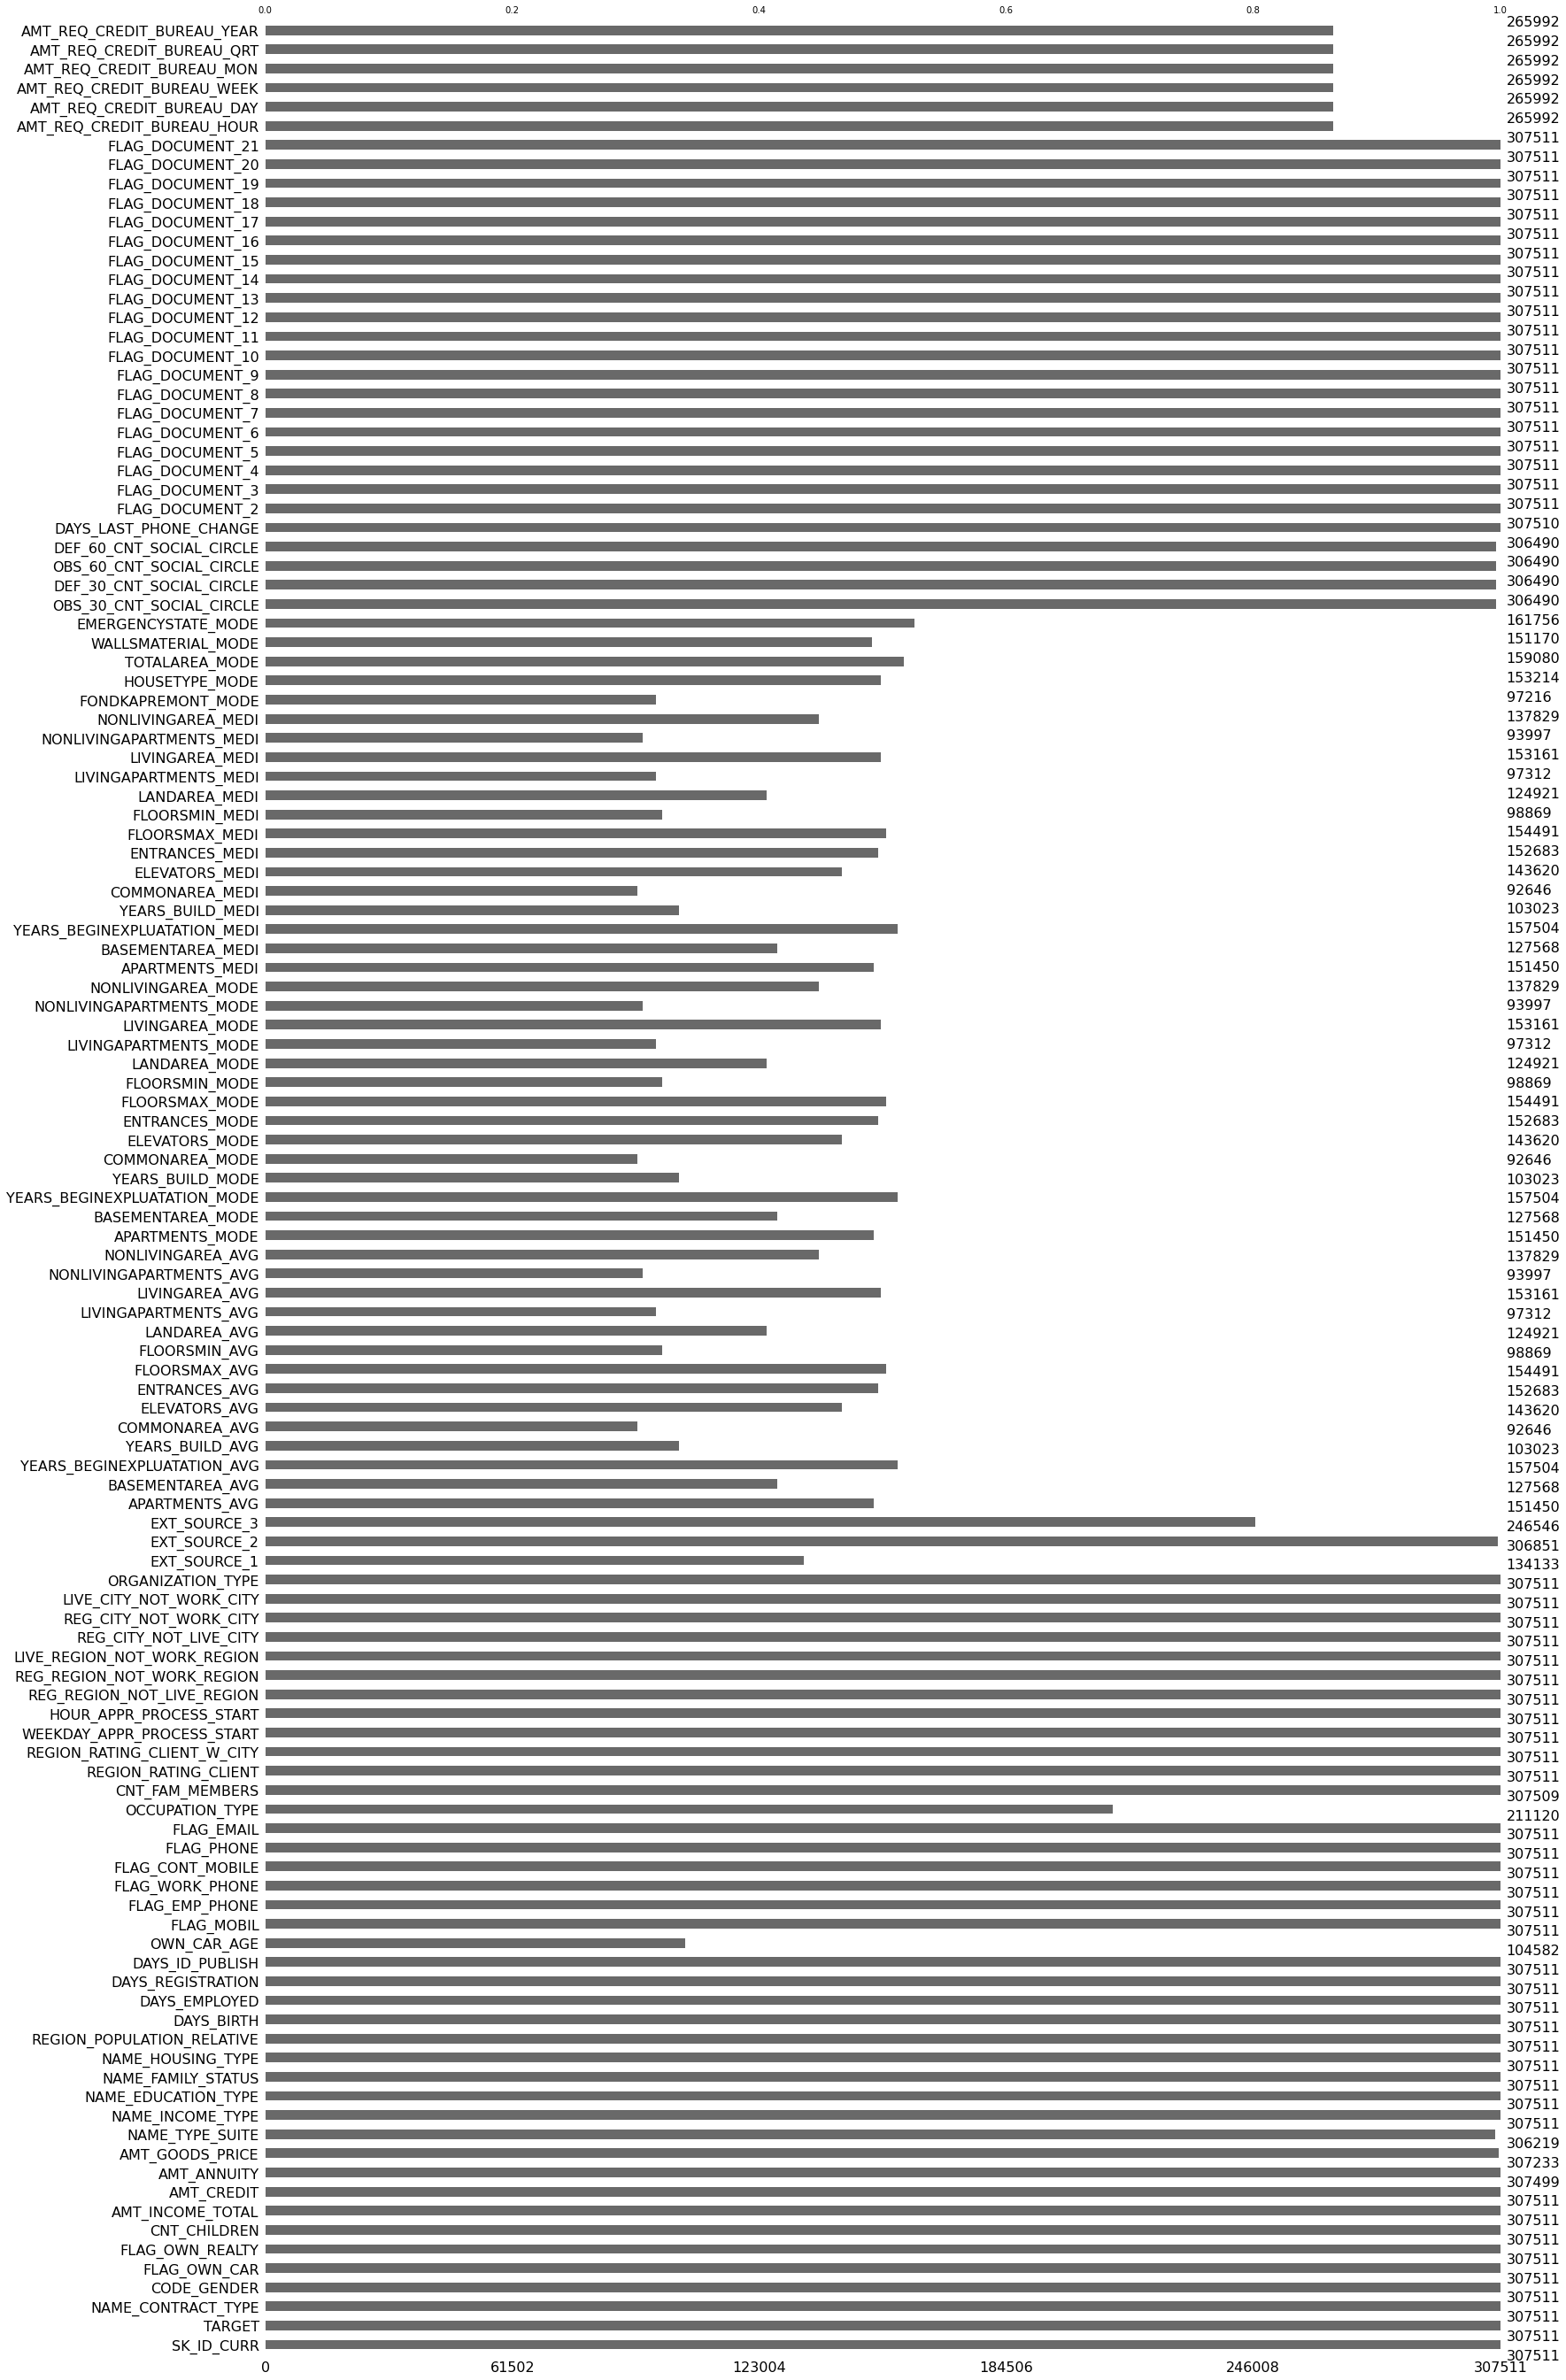

In [16]:
# Visualisation du remplissage des features
msno.bar(app_train)

**bureau**

In [17]:
traitement_NA_par_type(bureau)

,Total_NA,%_de_NA,Type
AMT_ANNUITY,1226791,71.473490,float64
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264,float64
DAYS_ENDDATE_FACT,633653,36.916958,float64
AMT_CREDIT_SUM_LIMIT,591780,34.477415,float64
AMT_CREDIT_SUM_DEBT,257669,15.011932,float64
DAYS_CREDIT_ENDDATE,105553,6.149573,float64
AMT_CREDIT_SUM,13,0.000757,float64


,Total_NA,%_de_NA,Type
AMT_ANNUITY,1226791,71.473490,float64
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264,float64
DAYS_ENDDATE_FACT,633653,36.916958,float64
AMT_CREDIT_SUM_LIMIT,591780,34.477415,float64
AMT_CREDIT_SUM_DEBT,257669,15.011932,float64
DAYS_CREDIT_ENDDATE,105553,6.149573,float64
AMT_CREDIT_SUM,13,0.000757,float64


**bureau_balance**

In [18]:
traitement_NA_par_type(bureau_balance)

,Total_NA,%_de_NA,Type


,Total_NA,%_de_NA,Type


**credit_card_balance**

In [19]:
traitement_NA_par_type(credit_card_balance)

,Total_NA,%_de_NA,Type
AMT_PAYMENT_CURRENT,767988,19.998063,float64
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_POS_CURRENT,749816,19.524872,float64
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872,float64
AMT_DRAWINGS_POS_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872,float64
CNT_INSTALMENT_MATURE_CUM,305236,7.948208,float64
AMT_INST_MIN_REGULARITY,305236,7.948208,float64


,Total_NA,%_de_NA,Type
AMT_PAYMENT_CURRENT,767988,19.998063,float64
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_POS_CURRENT,749816,19.524872,float64
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872,float64
AMT_DRAWINGS_POS_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872,float64
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872,float64
CNT_INSTALMENT_MATURE_CUM,305236,7.948208,float64
AMT_INST_MIN_REGULARITY,305236,7.948208,float64


**installments_payments**

In [20]:
traitement_NA_par_type(installments_payments)

,Total_NA,%_de_NA,Type
DAYS_ENTRY_PAYMENT,2905,0.021352,float64
AMT_PAYMENT,2905,0.021352,float64


,Total_NA,%_de_NA,Type
DAYS_ENTRY_PAYMENT,2905,0.021352,float64
AMT_PAYMENT,2905,0.021352,float64


**POS_CASH_balance**

In [21]:
traitement_NA_par_type(POS_CASH_balance)

,Total_NA,%_de_NA,Type
CNT_INSTALMENT_FUTURE,26087,0.260835,float64
CNT_INSTALMENT,26071,0.260675,float64


,Total_NA,%_de_NA,Type
CNT_INSTALMENT_FUTURE,26087,0.260835,float64
CNT_INSTALMENT,26071,0.260675,float64


**previous_app**

In [22]:
traitement_NA_par_type(previous_app)

,Total_NA,%_de_NA,Type
RATE_INTEREST_PRIVILEGED,1664263,99.643698,float64
RATE_INTEREST_PRIMARY,1664263,99.643698,float64
AMT_DOWN_PAYMENT,895844,53.636480,float64
RATE_DOWN_PAYMENT,895844,53.636480,float64
NAME_TYPE_SUITE,820405,49.119754,object
NFLAG_INSURED_ON_APPROVAL,673065,40.298129,float64
DAYS_TERMINATION,673065,40.298129,float64
DAYS_LAST_DUE,673065,40.298129,float64
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129,float64
DAYS_FIRST_DUE,673065,40.298129,float64


,Total_NA,%_de_NA,Type
RATE_INTEREST_PRIVILEGED,1664263,99.643698,float64
RATE_INTEREST_PRIMARY,1664263,99.643698,float64
AMT_DOWN_PAYMENT,895844,53.636480,float64
RATE_DOWN_PAYMENT,895844,53.636480,float64
NAME_TYPE_SUITE,820405,49.119754,object
NFLAG_INSURED_ON_APPROVAL,673065,40.298129,float64
DAYS_TERMINATION,673065,40.298129,float64
DAYS_LAST_DUE,673065,40.298129,float64
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129,float64
DAYS_FIRST_DUE,673065,40.298129,float64


# <span style="color: #8e44ad "> 3 - Analyse exploratoire </span>

## <span style="color: #8e44ad "> 3-1 - app_train </span>

In [23]:
app_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

### <span style="color: #8e44ad "> 3-1-1 - Name_contract_type </span>

In [24]:
app_train.NAME_CONTRACT_TYPE.value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

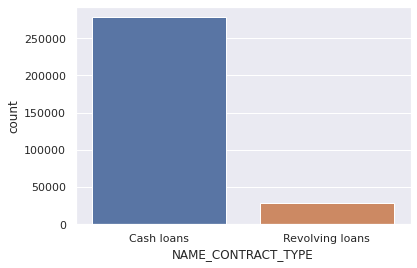

In [25]:
sns.set()
sns.countplot(x='NAME_CONTRACT_TYPE',data=app_train)

### <span style="color: #8e44ad "> 3-1-2 - Gender </span>

In [26]:
app_train.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

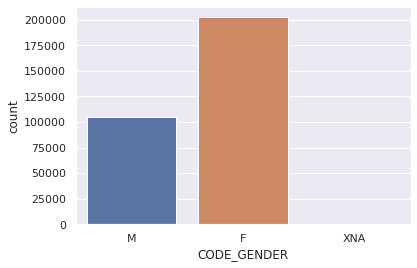

In [27]:
sns.set()
sns.countplot(x='CODE_GENDER',data=app_train)

### <span style="color: #8e44ad "> 3-1-3 - FLAG_OWN_CAR</span>  

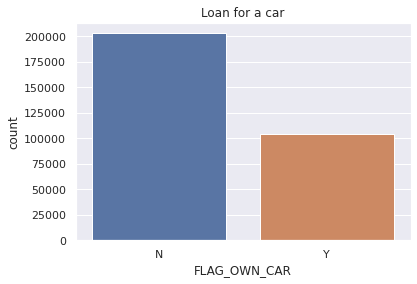

In [28]:
sns.set()
sns.countplot(x='FLAG_OWN_CAR',data=app_train)
_ = plt.title('Loan for a car')

### <span style="color: #8e44ad "> 3-1-4 - FLAG_OWN_REALTY </span>  

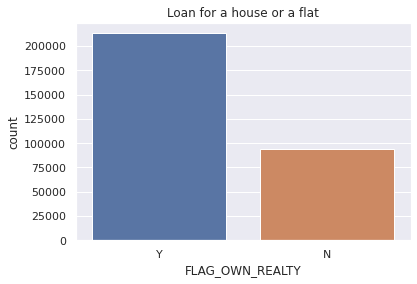

In [29]:
sns.set()
sns.countplot(x='FLAG_OWN_REALTY',data=app_train)
_ = plt.title('Loan for a house or a flat')

### <span style="color: #8e44ad "> 3-1-5 - CNT_CHILDREN </span>

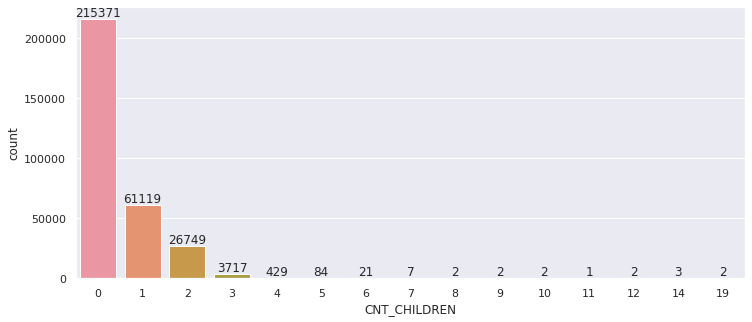

In [30]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.countplot(x='CNT_CHILDREN', data=app_train)
for container in ax.containers:
    ax.bar_label(container)

### <span style="color: #8e44ad "> 3-1-6 - AMT_INCOME_TOTAL </span>  
Income of the client

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

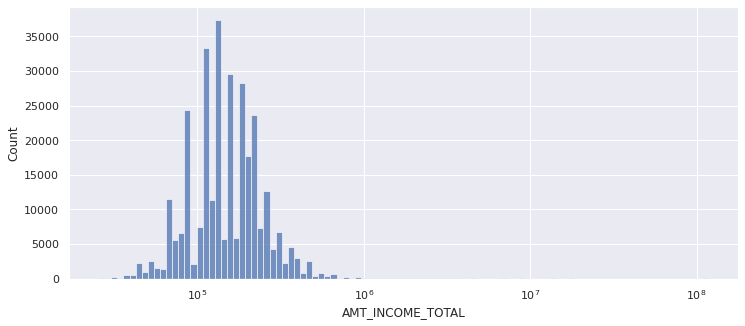

In [31]:
sns.set()
fig = plt.figure(figsize=(12,5))
sns.histplot(x='AMT_INCOME_TOTAL', data=app_train, log_scale=True, bins=100)

### <span style="color: #8e44ad "> 3-1-7 - Amount of credit </span>

<AxesSubplot:xlabel='AMT_CREDIT', ylabel='Count'>

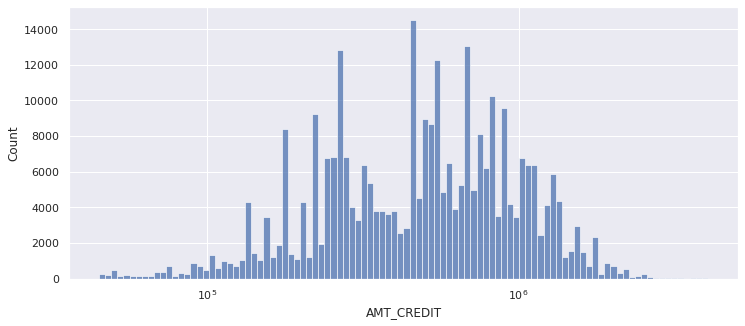

In [32]:
sns.set()
fig = plt.figure(figsize=(12,5))
sns.histplot(x='AMT_CREDIT',data=app_train, bins=100, log_scale=True)

### <span style="color: #8e44ad "> 3-1-8 - Amount of annuity </span>

<AxesSubplot:xlabel='AMT_ANNUITY', ylabel='Count'>

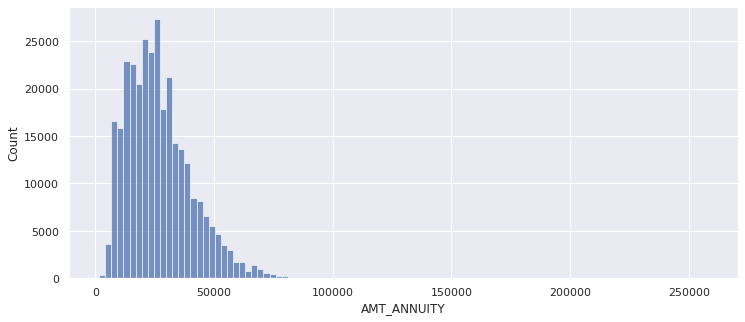

In [33]:
sns.set()
fig = plt.figure(figsize=(12,5))
sns.histplot(x='AMT_ANNUITY',data=app_train,bins=100)

### <span style="color: #8e44ad "> 3-1-9 - Price of goods </span>  
For consumer loans it is the price of the goods (les biens) for which the loan is given

<AxesSubplot:xlabel='AMT_GOODS_PRICE', ylabel='Count'>

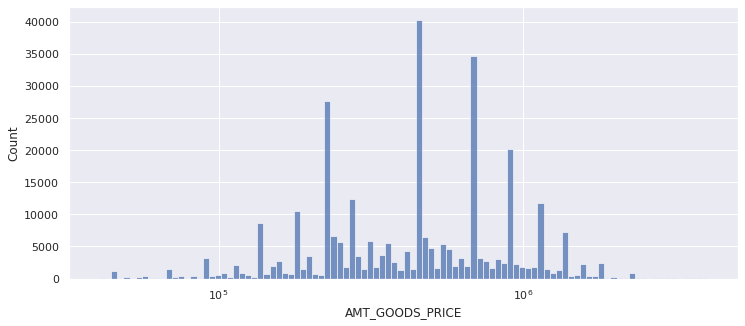

In [34]:
sns.set()
fig = plt.figure(figsize=(12,5))
sns.histplot(x='AMT_GOODS_PRICE',data=app_train,bins=100,log_scale=True)

### <span style="color: #8e44ad "> 3-1-10 - Who was accompanying client when he was applying for the loan </span>

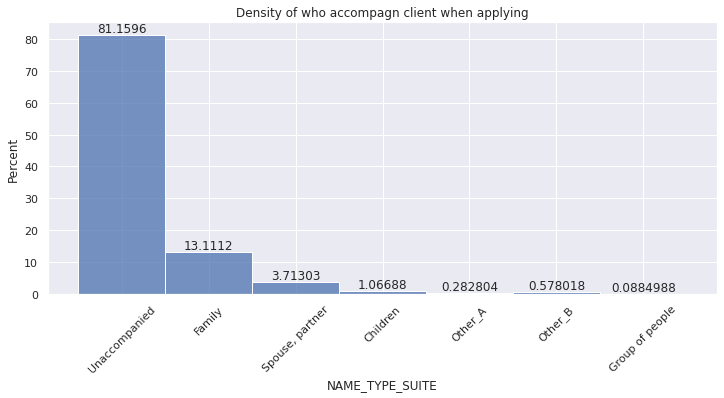

In [35]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.histplot(x='NAME_TYPE_SUITE', data=app_train, stat = 'percent')
for container in ax.containers:
    ax.bar_label(container)
_ = plt.title('Density of who accompagn client when applying')
_ = plt.xticks(rotation=45)

### <span style="color: #8e44ad "> 3-1-11 - Clients income type </span>

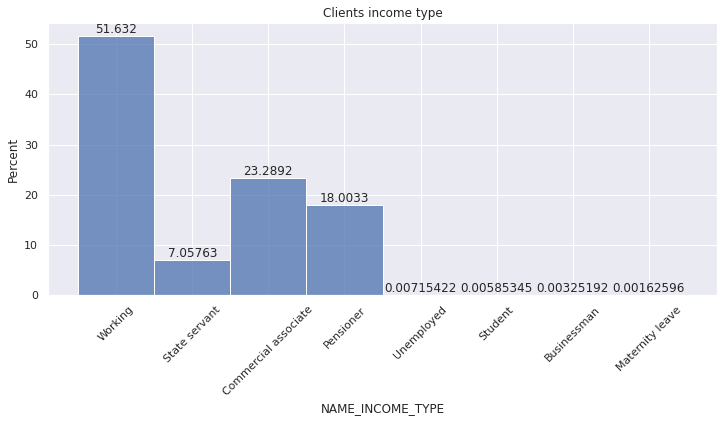

In [36]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.histplot(x='NAME_INCOME_TYPE',data=app_train, stat='percent')
for container in ax.containers:
    ax.bar_label(container)
_ = plt.title('Clients income type')
_ = plt.xticks(rotation=45)

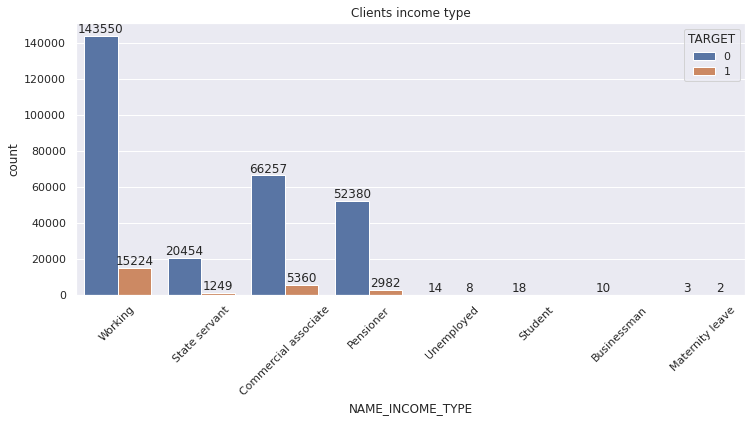

In [37]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.countplot(x='NAME_INCOME_TYPE', data=app_train, hue='TARGET')
_ = plt.title('Clients income type')
_ = plt.xticks(rotation=45)
for container in ax.containers:
    ax.bar_label(container)

### <span style="color: #8e44ad "> 3-1-12 - Level of highest education the client achieved </span>

In [38]:
app_train.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

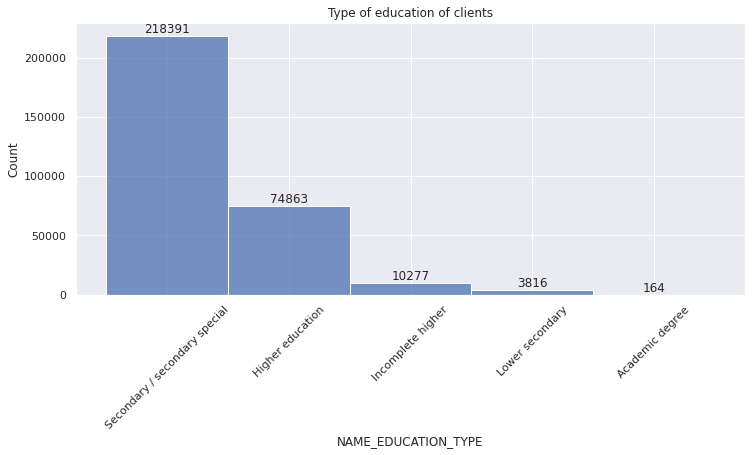

In [39]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.histplot(x='NAME_EDUCATION_TYPE',data=app_train)
for container in ax.containers:
    ax.bar_label(container)
_ = plt.title('Type of education of clients')
_ = plt.xticks(rotation=45)

### <span style="color: #8e44ad "> 3-1-13 - Family status of the client 	 </span>

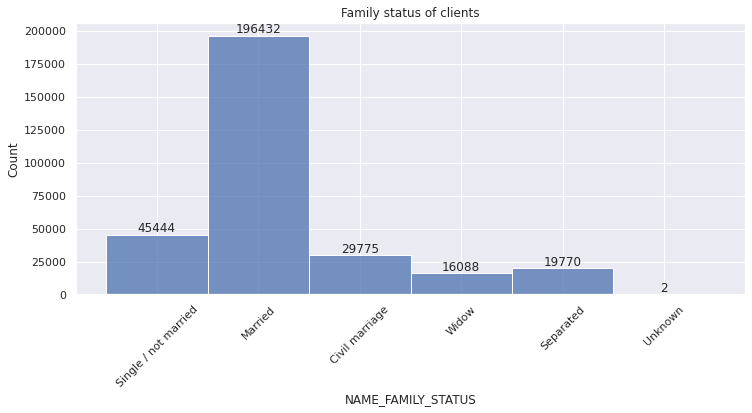

In [40]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.histplot(x='NAME_FAMILY_STATUS',data=app_train)
for container in ax.containers:
    ax.bar_label(container)
_ = plt.title('Family status of clients')
_ = plt.xticks(rotation=45)

### <span style="color: #8e44ad "> 3-1-14 - What kind of occupation does the client have </span>

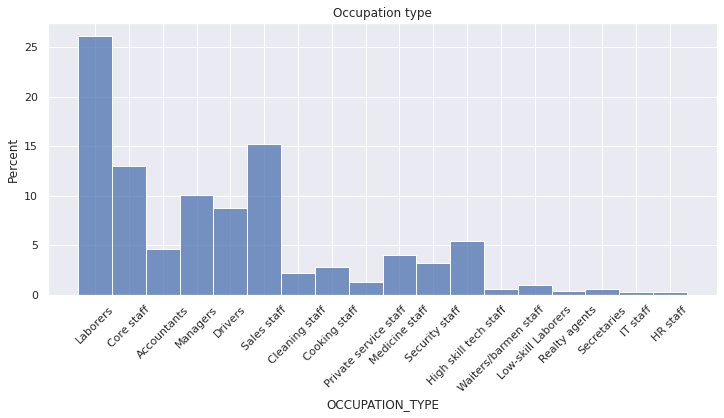

In [41]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.histplot(x='OCCUPATION_TYPE',data=app_train, stat ='percent')
# for container in ax.containers:
#     ax.bar_label(container)
_ = plt.title('Occupation type')
_ = plt.xticks(rotation=45)

### <span style="color: #8e44ad "> 3-1-15 - Type of organization where client works </span>

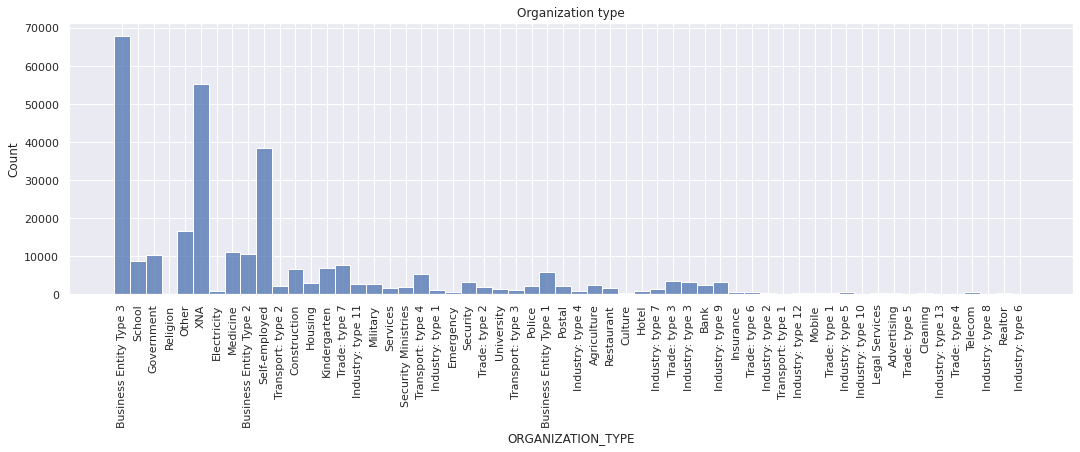

In [42]:
sns.set()
fig = plt.figure(figsize=(18,5))
ax = sns.histplot(x='ORGANIZATION_TYPE',data=app_train)
# for container in ax.containers:
#     ax.bar_label(container)
_ = plt.title('Organization type')
_ = plt.xticks(rotation=90)

In [43]:
app_train['OCCUPATION_TYPE'].isna().sum()

96391

### <span style="color: #8e44ad "> 3-1-15 - Target </span>

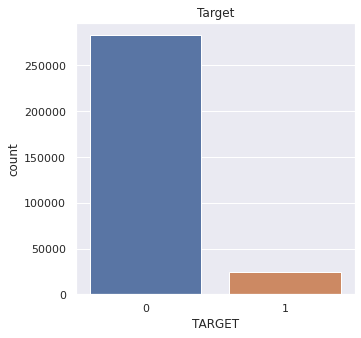

In [44]:
sns.set()
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='TARGET',data=app_train)
# for container in ax.containers:
#     ax.bar_label(container)
_ = plt.title('Target')

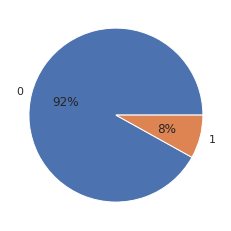

In [45]:
# Visualistation en %
target_temp = app_train.TARGET.value_counts(normalize=True).values
_ = plt.pie(target_temp,labels=['0', '1'], autopct='%.0f%%')

## <span style="color: #8e44ad "> 3-2 - previous_app </span>

In [46]:
previous_app.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [47]:
HomeCredit_columns_description[HomeCredit_columns_description['Table']=='previous_application.csv']

,Unnamed: 0,Table,Row,Description,Special
173,176,previous_application.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
175,178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
177,180,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the prev...,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
179,182,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application,NaN
180,183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN
181,184,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,NaN
182,185,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...,rounded


### <span style="color: #8e44ad "> 3-2-1 - Contract product type </span>

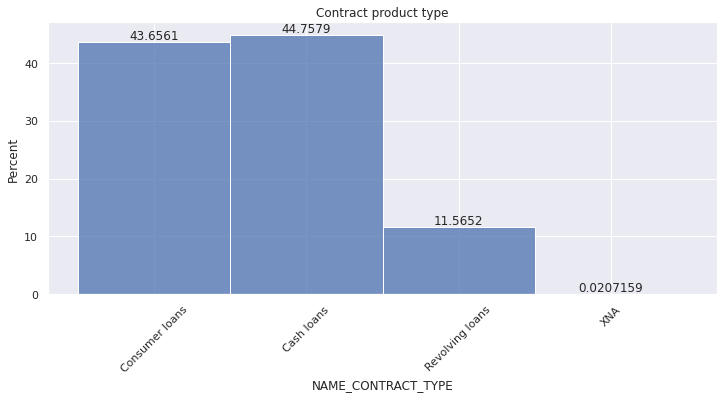

In [48]:
sns.set()
fig = plt.figure(figsize=(12,5))
ax = sns.histplot(x='NAME_CONTRACT_TYPE',data=previous_app, stat='percent')
for container in ax.containers:
    ax.bar_label(container)
_ = plt.title('Contract product type')
_ = plt.xticks(rotation=45)

### <span style="color: #8e44ad "> 3-2-2 - Purpose of the cash loan </span>

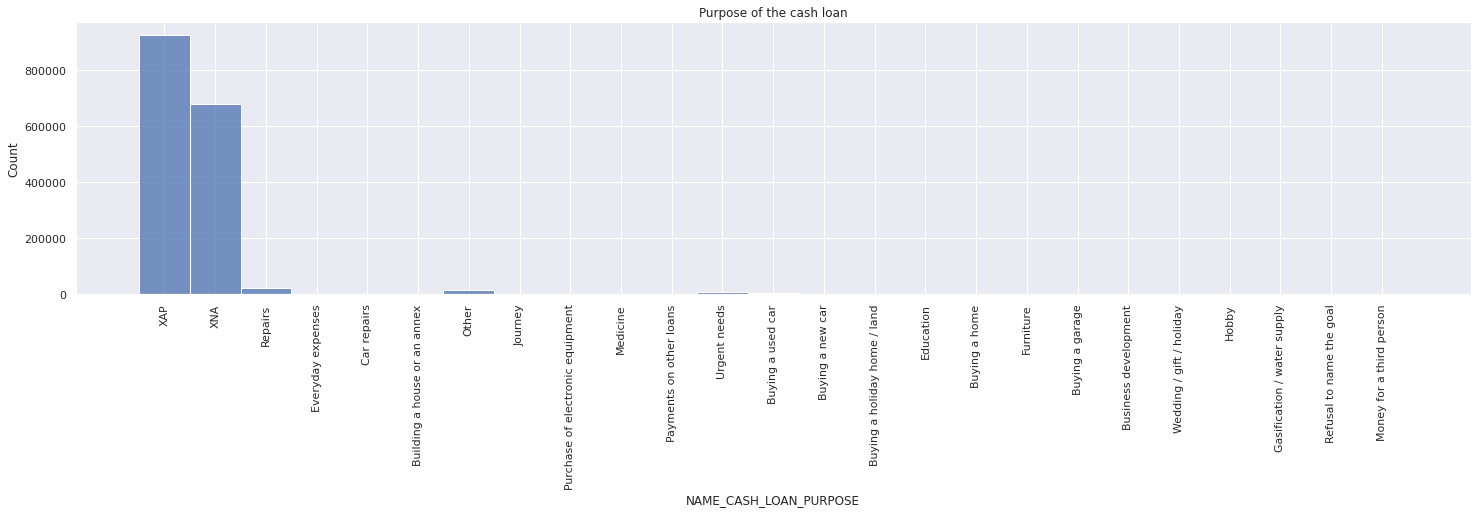

In [49]:
# sns.set()
fig = plt.figure(figsize=(25,5))
ax = sns.histplot(x='NAME_CASH_LOAN_PURPOSE', data=previous_app)
# for container in ax.containers:
#     ax.bar_label(container)
_ = plt.title('Purpose of the cash loan')
_ = plt.xticks(rotation=90)

### <span style="color: #8e44ad "> 3-2-3 - Contract approuved or not </span>

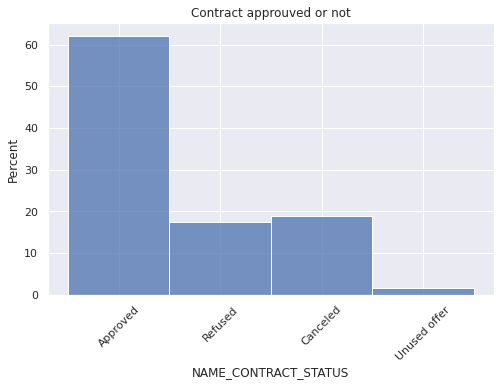

In [50]:
# sns.set()
fig = plt.figure(figsize=(8,5))
ax = sns.histplot(x='NAME_CONTRACT_STATUS', data=previous_app, stat = 'percent')
# for container in ax.containers:
#     ax.bar_label(container)
_ = plt.title('Contract approuved or not')
_ = plt.xticks(rotation=45)

# <span style="color: #8e44ad "> 4 - Features engineering </span>

In [51]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## <span style="color: #8e44ad "> 4-1 - Application train et test </span>

In [52]:
# Preprocess application_train.csv and application_test
def application_train_test(df_train, df_test, nan_as_category = False):
    # Merge datas
    df = pd.concat([df_train, df_test]).reset_index() 
    
    # Suppression des 4 XNA sur CODE_GENDER
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Featues catégorielles à 2 modalités (0 ou 1)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Remplacement de la valeur 365243 sur DAY_EMPLOYED par NaN puis par la moyenne par catégorie d'emploi
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # df['DAYS_EMPLOYED'].replace(365243, df['DAYS_EMPLOYED'].mean(), inplace= True)
    # df['DAYS_EMPLOYED']=df.groupby('OCCUPATION_TYPE')['DAYS_EMPLOYED'].apply(lambda x : x.fillna(x.mean()))

    
    # Ajout de quelques features (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

## <span style="color: #8e44ad "> 4-2 - Bureau et Bureau_balance </span>

In [53]:
# Preprocess bureau et bureau_balance
def bureau_and_balance(bureau, bureau_bal, nan_as_category = True):
    
    bb, bb_cat = one_hot_encoder(bureau_balance, True)
    bureau, bureau_cat = one_hot_encoder(bureau, True)
    
    # Bureau balance: Créations des aggrégations pour les données catégorielles
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)  # Créer un double index et applique les agrégations
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])  # Supprime le double index et le remplace par le nom des colonnes_min, max, etc
    
    # Regroupement des deux tables bureau et bureau_balance agrégé
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    
    # Suppresion de la colonne SK_ID_BUREAU et des dataframes temp
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    
    
    # Sur le nouveau dataframe (Bureau + bureau_balance agregé) 
    # Agrégation des données numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
        }
    # Agrégation des données catégorielles
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})  # Agrégation
    bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])  # Renomage des colonnes

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau

    return bureau_agg


## <span style="color: #8e44ad "> 4-3 - Previous_application </span>

In [54]:
# Preprocess previous_applications
def previous_applications(prev, nan_as_category = True):

    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Remplacement de la valeur 365243 values par NaN
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Ajout de la feature Valeur demandée / valeur reçue
    # prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']  # Attention, division par 0    
    prev['APP_CREDIT_PERC'] = np.where(prev['AMT_CREDIT'] != 0, prev['AMT_APPLICATION'] / prev['AMT_CREDIT'], 0)
    
    # Définition agrégations des features numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        }
    # Définition agrégation pour features catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications : Demande accordée - seulement les features numériques
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications : Demande refusée - seulement les features numériques
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev

    return prev_agg

## <span style="color: #8e44ad "> 4-4 - POS_CASH_balance </span>

In [55]:
# Preprocess POS_CASH_balance
def pos_cash(df, nan_as_category = True):

    pos, cat_cols = one_hot_encoder(df, nan_as_category= True)
    
    # Définition agrégations sur les features numériques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
        }
    # Définition agrégations sur les features catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Ajout d'une feature sur le nombre de remboursement effectué
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos

    return pos_agg

## <span style="color: #8e44ad "> 4-5 - Installments_payments </span>

In [56]:
# Preprocess installments_payments
def installment_payment(df, nan_as_category = True):

    ins, cat_cols = one_hot_encoder(df, nan_as_category= True)
    
    # Ajout des features du rapport et de la différence entre le montant payé et les versements
    # ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT'] if ins['AMT_INSTALMENT'] != 0 else 0
    ins['PAYMENT_PERC'] = ins.apply(lambda row: row.AMT_PAYMENT/row.AMT_INSTALMENT if row.AMT_INSTALMENT !=0 else 0, axis=1)  # A tester avec axis 0
    # ins['PAYMENT_PERC'] = np.where(ins['AMT_INSTALMENT'] != 0, ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT'], 0)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (avec suuppression des valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Définition agrégations sur les features numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
        }

    # Définition agrégations sur les features catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Apllication des agrégations
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Ajout d'une feature représentant le nombre de versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins

    return ins_agg


## <span style="color: #8e44ad "> 4-6 - credit_card_balance </span>

In [57]:
# Preprocess credit_card_balance
def credit_card_balance_prepro(df, nan_as_category = True):

    cc, cat_cols = one_hot_encoder(df, nan_as_category= True)
    
    # Définition des agrégations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Création d'une feature sur le nombre d'utilisation de la carte de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc

    return cc_agg

## <span style="color: #8e44ad "> 4-7 - Preprocessing </span>

In [58]:
t0 = time.time()

df = application_train_test(app_train, app_test)
print("Taille df app_train_test : ", df.shape)

bureau = bureau_and_balance(bureau, bureau_balance, nan_as_category = False)
print("Taille df bureau :", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau

previous_app = previous_applications(previous_app, nan_as_category = False)
print("Taille df previous_app :", previous_app.shape)
df = df.join(previous_app, how='left', on='SK_ID_CURR')
del previous_app

POS_CASH_balance = pos_cash(POS_CASH_balance, nan_as_category = False)
print("Taille df POS_CASH_balance :", POS_CASH_balance.shape)
df = df.join(POS_CASH_balance, how='left', on='SK_ID_CURR')
del POS_CASH_balance

installments_payments = installment_payment(installments_payments, nan_as_category = False)
print("Taille df installments_payments :", installments_payments.shape)
df = df.join(installments_payments, how='left', on='SK_ID_CURR')
del installments_payments

credit_card_balance = credit_card_balance_prepro(credit_card_balance,  nan_as_category = False)
print("Taille df credit_card_balance :", credit_card_balance.shape)
df = df.join(credit_card_balance, how='left', on='SK_ID_CURR')
del credit_card_balance

print("Temps de preprocessing : ", round(time.time() - t0, 2), ' secondes')
print("\nTaille du df nettoyé : ", df.shape)

Taille df app_train_test :  (356251, 248)
Taille df bureau : (305811, 116)
Taille df previous_app : (338857, 249)
Taille df POS_CASH_balance : (337252, 18)
Taille df installments_payments : (339587, 26)
Taille df credit_card_balance : (103558, 141)
Temps de preprocessing :  293.06  secondes

Taille du df nettoyé :  (356251, 798)


# <span style="color: #8e44ad "> 5 - Export des données </span>

In [59]:
# Sauvegarde du dataframe
df.to_csv('Data_preprocessed.csv', sep=',', index=False)

In [60]:
# Sauvegarde des valeurs des histogrammes pour le Dashboard
liste_hist = ['NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']
dictionnaire_hist = {}

for l in liste_hist:
    dictionnaire_hist[l] = {'Financement accepté' : app_train[app_train['TARGET'] == 0][l].value_counts(),
                            'Financement refusé' : app_train[app_train['TARGET'] == 1][l].value_counts()}

pickle.dump(dictionnaire_hist, open('./Dashboard/dictionnaire_hist' + '.pickle', 'wb'))

In [61]:
# Sauvegarde des données catégorielles clients pour le positionner dans le dashbord (à faire sans le OHE)
liste_hist_export = ['SK_ID_CURR', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']
df_hist_export = app_test[liste_hist_export]

pickle.dump(df_hist_export, open('./Dashboard/df_hist_export' + '.pickle', 'wb'))